In [40]:
import requests
import xmltodict
import time
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import json
import datetime

url_base = "http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19InfStateJson"
url_serviceKey = "KnX7gS3IcFpLrsPU6bpzDfCWZeGbNa7xOwC0g5Kjqg5CQ24mMTscxLL%2FjuM4WCfrBfgcnTMHOgx4xn5zr7pHLQ%3D%3D"
url_pages = "1000" #페이지당열갯수
url_start_date = "20200101" #시작날짜
url_end_date = "20210930" #끝날짜
url = url_base + "?serviceKey=" + url_serviceKey + "&pageNo=1&numOfRows=" + url_pages + "&startCreateDt="+ url_start_date + "&endCreateDt=" + url_end_date

req = requests.get(url).content

xmlObject = xmltodict.parse(req)
dict_data = xmlObject['response']['body']['items']['item']

df = pd.DataFrame(dict_data)

df = df.astype({'decideCnt' : 'int', 'examCnt' : 'int', 'deathCnt' : 'int'})

df = df.drop_duplicates(['stateDt']) # 중복제거: 하루에 2회 이상 중복 확진자 발표가 있을 경우 마지막 발표한 것으로 대체

df['date']=df['stateDt']
df['date'] = pd.to_datetime(df['date']) #시계열지정
df.set_index('date')

df_2 = df[['date','decideCnt']]
df_2 = df_2.sort_values(by='date') #diff()를 사용하기 위해서 날짜로 오름차순 정렬
df_2['daily_decideCnt'] = df_2['decideCnt'].diff()

#result = []
inf_columns = ["date", "decideCnt", "daily_decideCnt"]
result_df = pd.DataFrame(df_2, columns = inf_columns)
result_df.to_csv('2020_2021_확진자.csv', mode='w', index=False, encoding='cp949')


<AxesSubplot:xlabel='date'>

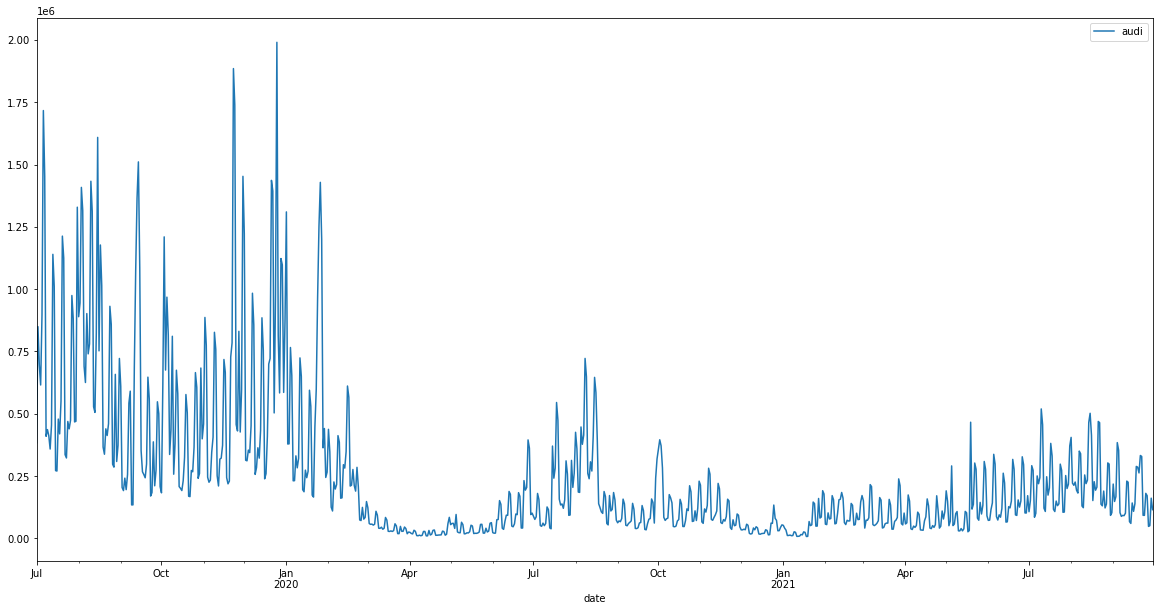

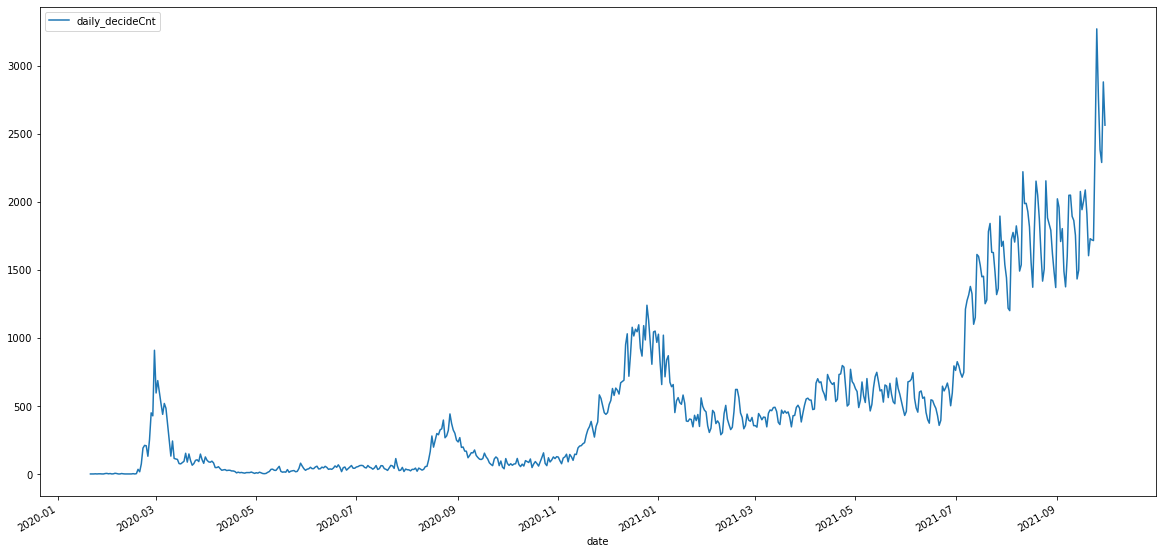

In [43]:
moviedate = 20200401
audi_num = []
movie_date = []

dt_index = pd.date_range(start='20190701', end='20210930')
dt_list = dt_index.strftime("%Y%m%d").tolist()

for i in dt_list:
    count = 0
    url = 'http://kobis.or.kr/kobisopenapi/webservice/rest/boxoffice/searchDailyBoxOfficeList.json?key=157166e401ac787728b1c7400617acf9&targetDt='+i
    res = requests.get(url)
    text= res.text
    d = json.loads(text)
    
    for b in d['boxOfficeResult']['dailyBoxOfficeList']:
        count += int(b['audiCnt'])
    
    movie_date.append(i)
    audi_num.append(count)
    count = 0

movie_dic = {
    'date':movie_date,
    'audi':audi_num
}

movie_df = pd.DataFrame(movie_dic)
movie_df = movie_df.astype({'audi' : 'int'})
movie_df['date'] = pd.to_datetime(movie_df['date']) #시계열지정
movie_df.set_index('date')
movie_df.to_csv("movie_audi.csv", mode='w', encoding='cp949', index=False)

plt.rcParams['figure.figsize'] = [20,10]

<AxesSubplot:xlabel='date'>

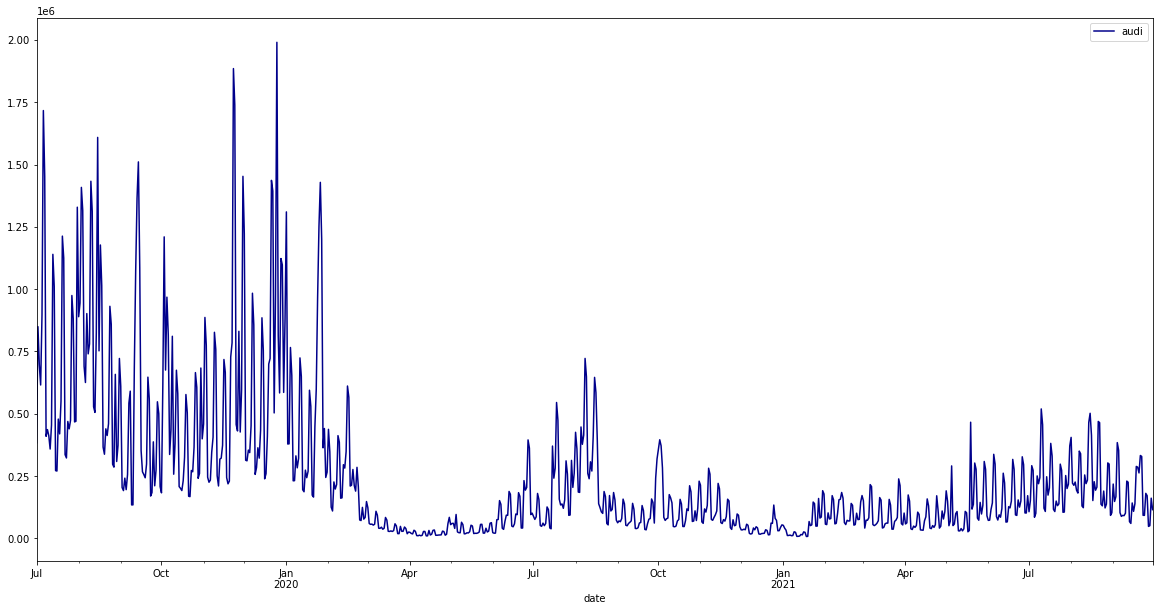

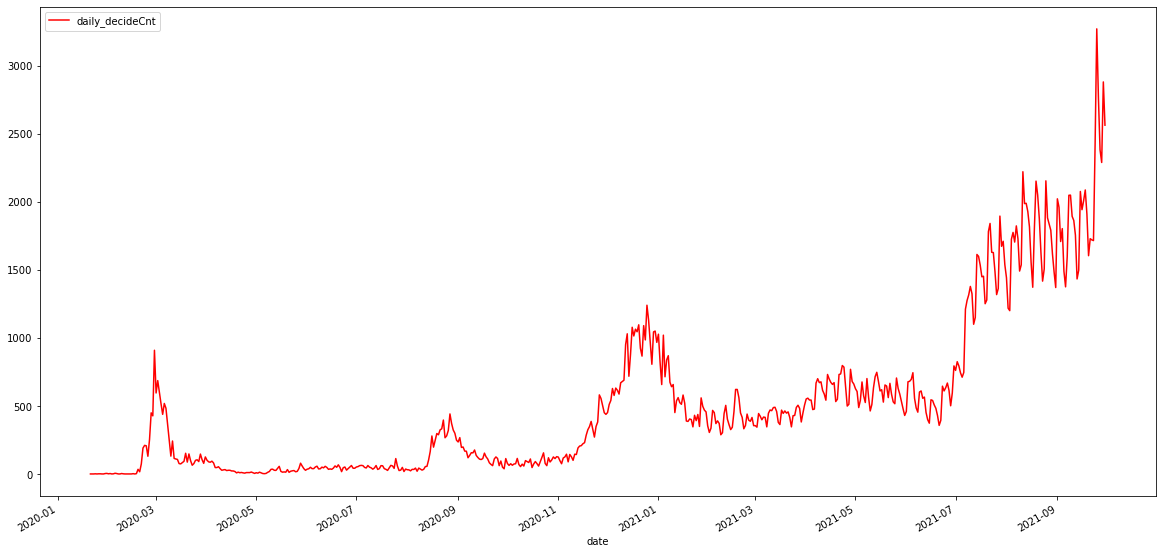

In [63]:
movie_df.plot('date', ['audi'], color='Darkblue')
result_df.plot('date', ['daily_decideCnt'], color='Red')

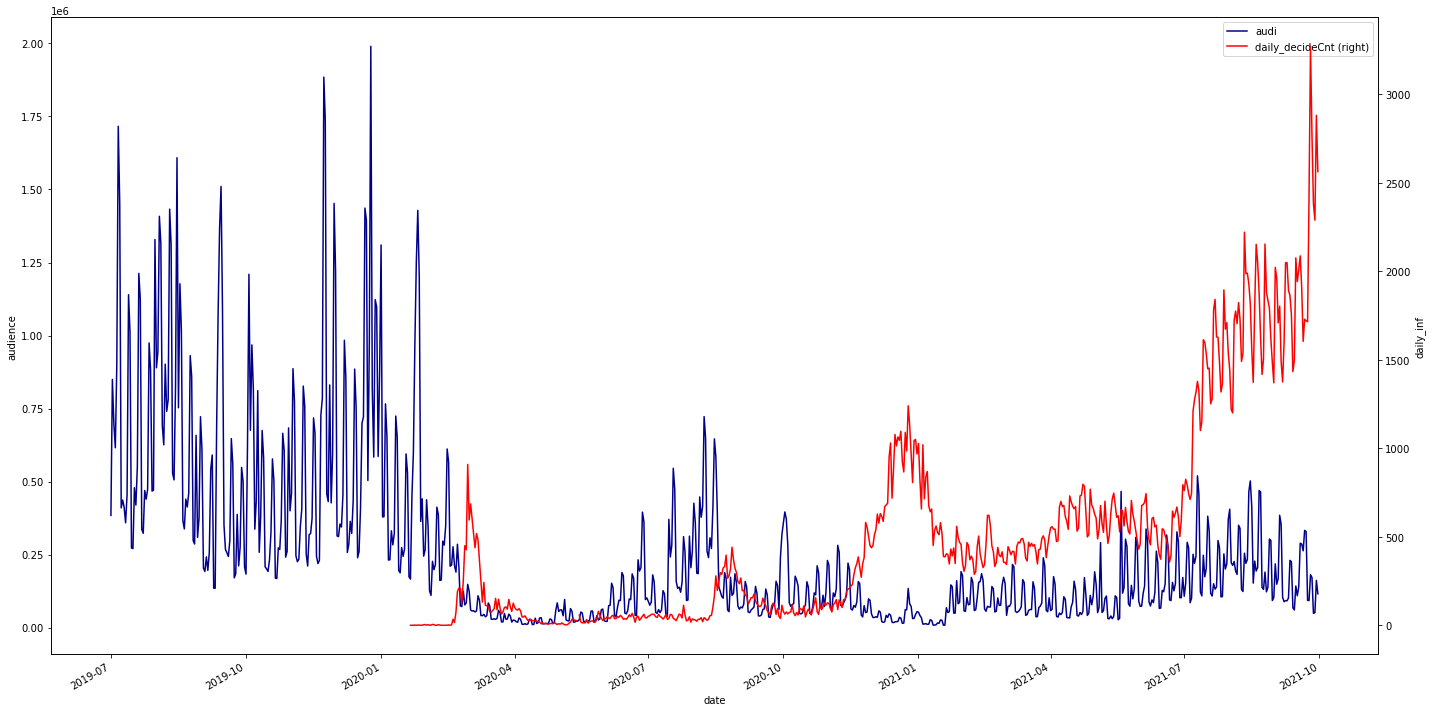

In [62]:
merge_data = pd.merge(result_df, movie_df, how='outer', on='date')
merge_data.to_csv("merged.csv", mode='w', encoding='cp949', index=False)

ax=merge_data.plot(kind='line', x='date', y='audi', color='DarkBlue')
ax2=merge_data.plot(kind='line', x='date', y='daily_decideCnt', secondary_y=True,color='Red', ax=ax)

ax.set_ylabel('audience')
ax2.set_ylabel('daily_inf')
plt.tight_layout()
plt.show()